## Imports And Data Loading

In [1]:
import os
import numpy as np
import scipy.io
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnext101_32x8d
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.optim.lr_scheduler as lr_scheduler

mat = scipy.io.loadmat('/kaggle/input/imagelabel/imagelabels (1).mat')
labels = mat['labels'][0]

def list_image_files(image_dir):
    image_paths = []
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(image_dir, filename))
    return image_paths

dataset_path = '/kaggle/input/102flowers/102flower'
image_paths = list_image_files(dataset_path)

assert len(image_paths) == len(labels), "Number of images and labels must match"

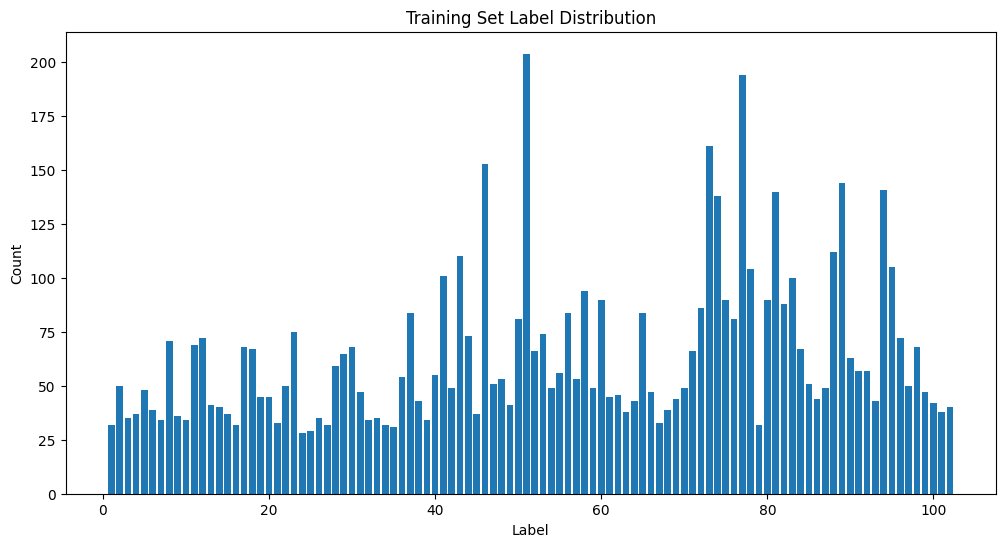

Training set label counts: Counter({51: 204, 77: 194, 73: 161, 46: 153, 89: 144, 94: 141, 81: 140, 74: 138, 88: 112, 43: 110, 95: 105, 78: 104, 41: 101, 83: 100, 58: 94, 75: 90, 80: 90, 60: 90, 82: 88, 72: 86, 37: 84, 56: 84, 65: 84, 50: 81, 76: 81, 23: 75, 53: 74, 44: 73, 12: 72, 96: 72, 8: 71, 11: 69, 30: 68, 17: 68, 98: 68, 84: 67, 18: 67, 71: 66, 52: 66, 29: 65, 90: 63, 28: 59, 92: 57, 91: 57, 55: 56, 40: 55, 36: 54, 48: 53, 57: 53, 85: 51, 47: 51, 97: 50, 2: 50, 22: 50, 59: 49, 87: 49, 54: 49, 70: 49, 42: 49, 5: 48, 99: 47, 31: 47, 66: 47, 62: 46, 20: 45, 61: 45, 19: 45, 69: 44, 86: 44, 38: 43, 64: 43, 93: 43, 100: 42, 49: 41, 13: 41, 14: 40, 102: 40, 68: 39, 6: 39, 63: 38, 101: 38, 4: 37, 45: 37, 15: 37, 9: 36, 3: 35, 26: 35, 33: 35, 7: 34, 32: 34, 10: 34, 39: 34, 67: 33, 21: 33, 79: 32, 1: 32, 27: 32, 34: 32, 16: 32, 35: 31, 25: 29, 24: 28})


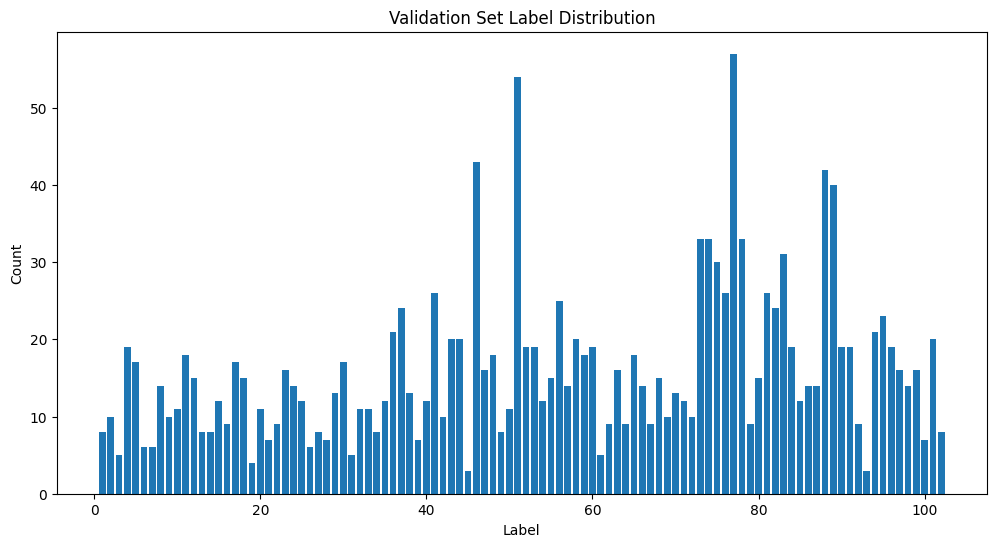

Validation set label counts: Counter({77: 57, 51: 54, 46: 43, 88: 42, 89: 40, 78: 33, 74: 33, 73: 33, 83: 31, 75: 30, 81: 26, 41: 26, 76: 26, 56: 25, 37: 24, 82: 24, 95: 23, 36: 21, 94: 21, 44: 20, 58: 20, 43: 20, 101: 20, 91: 19, 96: 19, 90: 19, 84: 19, 4: 19, 52: 19, 53: 19, 60: 19, 48: 18, 59: 18, 11: 18, 65: 18, 5: 17, 30: 17, 17: 17, 63: 16, 23: 16, 99: 16, 47: 16, 97: 16, 18: 15, 68: 15, 80: 15, 55: 15, 12: 15, 57: 14, 86: 14, 98: 14, 8: 14, 24: 14, 66: 14, 87: 14, 29: 13, 38: 13, 70: 13, 40: 12, 15: 12, 71: 12, 25: 12, 54: 12, 35: 12, 85: 12, 32: 11, 50: 11, 20: 11, 33: 11, 10: 11, 2: 10, 69: 10, 9: 10, 72: 10, 42: 10, 16: 9, 79: 9, 92: 9, 62: 9, 64: 9, 22: 9, 67: 9, 27: 8, 34: 8, 14: 8, 1: 8, 13: 8, 102: 8, 49: 8, 100: 7, 28: 7, 21: 7, 39: 7, 7: 6, 6: 6, 26: 6, 3: 5, 31: 5, 61: 5, 19: 4, 45: 3, 93: 3})


In [2]:
import matplotlib.pyplot as plt
from collections import Counter

image_paths_train, image_paths_val, labels_train, labels_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

label_counts_train = Counter(labels_train)

label_counts_val = Counter(labels_val)

plt.figure(figsize=(12, 6))
plt.bar(label_counts_train.keys(), label_counts_train.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')
plt.show()

print("Training set label counts:", label_counts_train)

# Plot the distribution of labels in the validation set
plt.figure(figsize=(12, 6))
plt.bar(label_counts_val.keys(), label_counts_val.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Validation Set Label Distribution')
plt.show()

print("Validation set label counts:", label_counts_val)


## Dataset Class

In [3]:
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, return_pairs=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.return_pairs = return_pairs

    def __len__(self):
        return len(self.image_paths)

    def load_and_preprocess_image(self, filepath):
        img = Image.open(filepath).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

    def __getitem__(self, index):
        img1 = self.load_and_preprocess_image(self.image_paths[index])
        label1 = self.labels[index]

        if self.return_pairs:
            if np.random.rand() > 0.5:
                similar_indices = np.where(self.labels == label1)[0]
                similar_indices = similar_indices[similar_indices != index]
                index2 = np.random.choice(similar_indices)
            else:
                dissimilar_indices = np.where(self.labels != label1)[0]
                weights = [1 / label_counts[self.labels[idx]] for idx in dissimilar_indices]
                index2 = np.random.choice(dissimilar_indices, p=weights/np.sum(weights))

            img2 = self.load_and_preprocess_image(self.image_paths[index2])
            label2 = self.labels[index2]
            pair_label = 1 if label1 == label2 else 0

            return (img1, img2), pair_label
        else:
            return img1, label1

image_paths_train, image_paths_temp, labels_train, labels_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels)  # Stratified split

## Data prepration

In [4]:
image_paths_val, image_paths_test, labels_val, labels_test = train_test_split(
    image_paths_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

# Compute dataset mean and std
simple_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create a dataset with all image paths and labels
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

train_dataset_full = FlowerDataset(image_paths_train, labels_train, transform=simple_transform, return_pairs=False)
mean, std = compute_mean_std(train_dataset_full)
print('Computed mean:', mean)
print('Computed std:', std)

# Use the computed mean and std for normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

label_counts = Counter(labels_train)
train_dataset = FlowerDataset(image_paths_train, labels_train, transform=transform)
val_dataset = FlowerDataset(image_paths_val, labels_val, transform=transform)
test_dataset = FlowerDataset(image_paths_test, labels_test, transform=transform)

Computed mean: tensor([0.4348, 0.3772, 0.2879])
Computed std: tensor([0.2587, 0.2046, 0.2118])


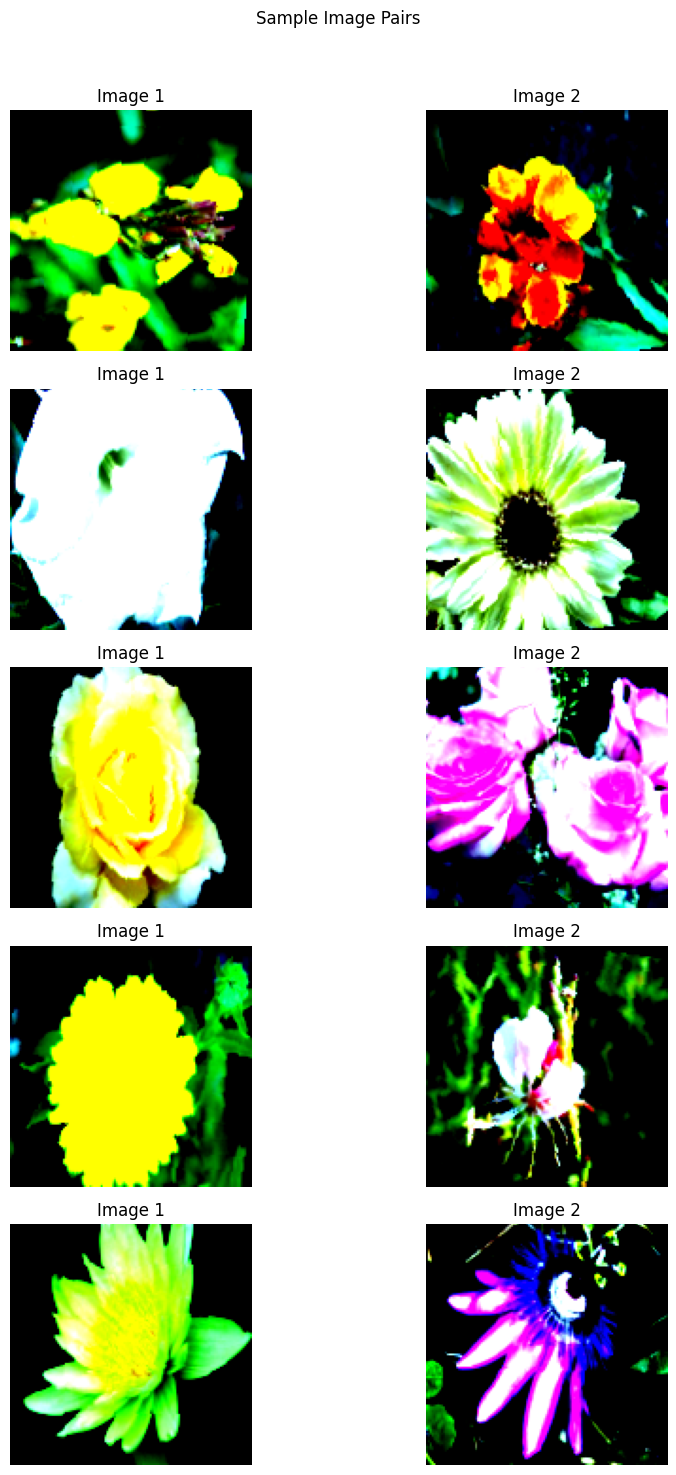

In [5]:
def visualize_image_pairs(dataset, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 3))
    fig.suptitle('Sample Image Pairs')

    for i in range(num_pairs):
        (img1, img2), label = dataset[i]

        img1 = transforms.ToPILImage()(img1.cpu().clamp(0, 1))
        img2 = transforms.ToPILImage()(img2.cpu().clamp(0, 1))

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title('Image 1')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title('Image 2')
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_image_pairs(train_dataset, num_pairs=5)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Model Definition

In [7]:
class DeeperSiameseNetwork(nn.Module):
    def __init__(self):
        super(DeeperSiameseNetwork, self).__init__()
        self.base_model = resnext101_32x8d(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )

    def forward_one(self, x):
        return self.base_model(x)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

model = DeeperSiameseNetwork()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:02<00:00, 169MB/s]  


In [8]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes=102, feat_dim=128, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss


## The Training Process

/tmp/ipykernel_34/477643175.py:16: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1519.)
  distmat.addmm_(1, -2, x, self.centers.t())


Epoch [1/40], Loss: 0.6654, Center Loss: 503.1424, Val Loss: 0.5886, Val ROC AUC: 0.8445, Train Accuracy: 0.5070, Val Accuracy: 0.7590
Epoch [2/40], Loss: 0.6166, Center Loss: 499.4506, Val Loss: 0.5809, Val ROC AUC: 0.8329, Train Accuracy: 0.6424, Val Accuracy: 0.7590
Epoch [3/40], Loss: 0.6025, Center Loss: 496.5351, Val Loss: 0.5839, Val ROC AUC: 0.8419, Train Accuracy: 0.7294, Val Accuracy: 0.7785
Epoch [4/40], Loss: 0.6000, Center Loss: 493.2608, Val Loss: 0.5785, Val ROC AUC: 0.8482, Train Accuracy: 0.7380, Val Accuracy: 0.7622
Epoch [5/40], Loss: 0.5886, Center Loss: 490.4038, Val Loss: 0.5862, Val ROC AUC: 0.8481, Train Accuracy: 0.7531, Val Accuracy: 0.7671
Epoch [6/40], Loss: 0.5835, Center Loss: 487.8390, Val Loss: 0.5604, Val ROC AUC: 0.8685, Train Accuracy: 0.7716, Val Accuracy: 0.7956
Epoch [7/40], Loss: 0.5851, Center Loss: 485.3362, Val Loss: 0.5678, Val ROC AUC: 0.8720, Train Accuracy: 0.7706, Val Accuracy: 0.7891
Epoch [8/40], Loss: 0.5787, Center Loss: 480.7807, Val 

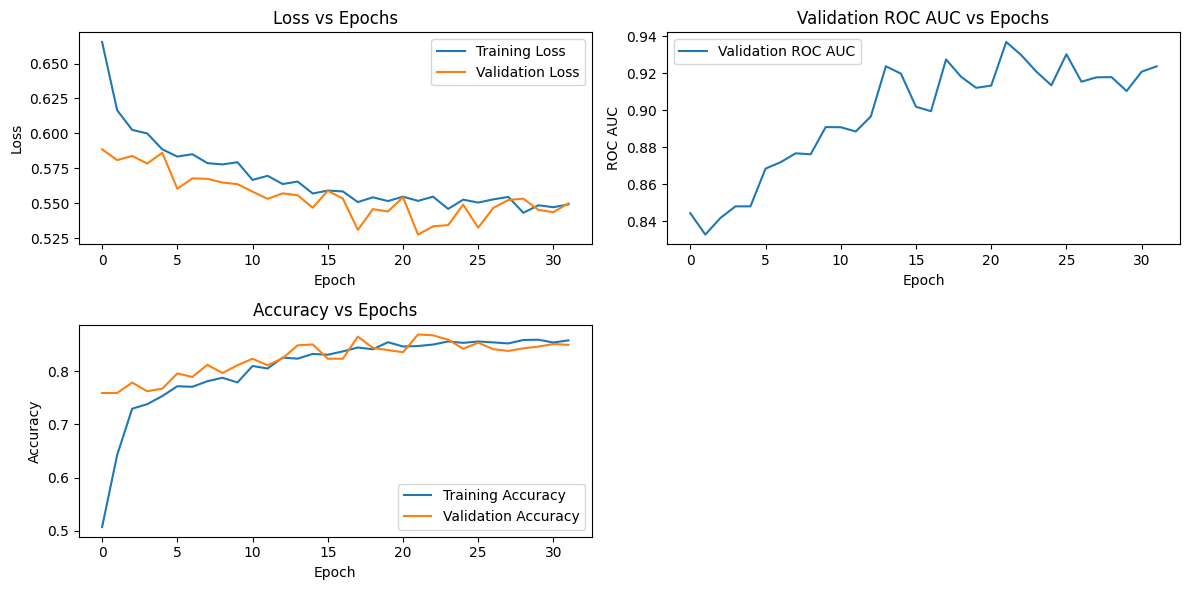

In [9]:
center_loss = CenterLoss(num_classes=len(np.unique(labels)), feat_dim=128, use_gpu=torch.cuda.is_available())

# Initialize BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Move model and criterion to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    center_loss = center_loss.cuda()

# Construct optimizers
params = list(model.parameters()) + list(center_loss.parameters())
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Optimizers
optimizer_centloss = optim.Adam(center_loss.parameters(), lr=1e-5)

# StepLR scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler_centloss = lr_scheduler.StepLR(optimizer_centloss, step_size=10, gamma=0.5)

def cosine_similarity(x1, x2):
    return nn.functional.cosine_similarity(x1, x2, dim=1)

def train(model, center_loss, train_loader, val_loader, criterion, optimizer, optimizer_centloss, scheduler, scheduler_centloss, center_loss_weight=0.005, num_epochs=30, patience=5):
    history = {'loss': [], 'center_loss': [], 'val_loss': [], 'val_roc_auc': [], 'train_accuracy': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_center_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for (img1, img2), labels in train_loader:
            if torch.cuda.is_available():
                img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()

            optimizer.zero_grad()
            optimizer_centloss.zero_grad()

            output1, output2 = model(img1, img2)
            similarity = cosine_similarity(output1, output2)
            loss = criterion(similarity, labels.float())
            closs = center_loss(output1, labels) + center_loss(output2, labels)
            total_loss = loss + center_loss_weight * closs

            total_loss.backward()
            optimizer.step()
            optimizer_centloss.step()

            running_loss += loss.item() * img1.size(0)
            running_center_loss += closs.item() * img1.size(0)

            preds = (similarity > 0.5).float()
            running_corrects += torch.sum(preds == labels.float())
            total_samples += labels.size(0)

        scheduler.step()
        scheduler_centloss.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_center_loss = running_center_loss / len(train_loader.dataset)
        epoch_accuracy = running_corrects.double() / total_samples

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_labels = []
        val_preds = []
        with torch.no_grad():
            for (img1, img2), labels in val_loader:
                if torch.cuda.is_available():
                    img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()

                output1, output2 = model(img1, img2)
                similarity = cosine_similarity(output1, output2)
                loss = criterion(similarity, labels.float())
                val_running_loss += loss.item() * img1.size(0)

                preds = (similarity > 0.5).float()
                val_running_corrects += torch.sum(preds == labels.float())
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(similarity.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_running_corrects.double() / len(val_loader.dataset)

        try:
            val_roc_auc = roc_auc_score(val_labels, val_preds)
        except ValueError as e:
            print(f'Error in ROC AUC calculation at epoch {epoch+1}: {e}')
            val_roc_auc = float('nan')

        history['loss'].append(epoch_loss)
        history['center_loss'].append(epoch_center_loss)
        history['val_loss'].append(val_loss)
        history['val_roc_auc'].append(val_roc_auc)
        history['train_accuracy'].append(epoch_accuracy.item())
        history['val_accuracy'].append(val_accuracy.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Center Loss: {epoch_center_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, history

# Training the model
model, history = train(model, center_loss, train_loader, val_loader, criterion, optimizer, optimizer_centloss, scheduler, scheduler_centloss, center_loss_weight=0.00005, num_epochs=40, patience=10)

# Testing function
def test(model, test_loader, criterion):
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for (img1, img2), labels in test_loader:
            if torch.cuda.is_available():
                img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()

            output1, output2 = model(img1, img2)
            similarity = cosine_similarity(output1, output2)
            loss = criterion(similarity, labels.float())
            test_running_loss += loss.item() * img1.size(0)

            preds = (similarity > 0.5).float()
            test_running_corrects += torch.sum(preds == labels.float())
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(similarity.cpu().numpy())

    test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = test_running_corrects.double() / len(test_loader.dataset)
    try:
        test_roc_auc = roc_auc_score(test_labels, test_preds)
    except ValueError as e:
        print(f'Error in ROC AUC calculation: {e}')
        test_roc_auc = float('nan')

    print(f'Test Loss: {test_loss:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_roc_auc, test_accuracy

# Testing the model
test_loss, test_roc_auc, test_accuracy = test(model, test_loader, criterion)

# Plotting the history
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

plt.subplot(2, 2, 2)
plt.plot(history['val_roc_auc'], label='Validation ROC AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Validation ROC AUC vs Epochs')

plt.subplot(2, 2, 3)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()